In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings
import numpy as np
from copy import deepcopy

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

from lib.prepare_data import get_predict_set
from lib.merge import prepare_train_show


In [2]:
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = sys.executable

spark = SparkSession.builder.appName("renovation").getOrCreate()


In [3]:
# import files
# File location and type
file_location_array = [
    {
        "location": "../training/pred_renov.csv",
        "name": "pred_renov_no_diff",
        "delimiter": ",",
    },
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"},
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )


In [4]:
# cast variables if necessary
training_renov_no_diff = (
    dataframes["pred_renov_no_diff"].withColumns({
        "surface": (
            F.when(F.col("surface") == "null", np.nan).otherwise(
                F.col("surface").cast("int")
            )
        ),
        "heating_production": (
            F.when(F.col("heating_production") == "null", np.nan).otherwise(
                F.col("heating_production").cast("int")
            )
        ),
    })
)
dictionary = dataframes["dictionary"]


In [5]:
# linear
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBClassifier

# hyperparams
from scipy.stats import uniform, randint


0.62309670781893 {'C': 941.4585843529143, 'class_weight': 'balanced', 'max_iter': 1000}
0.7124742798353909 {'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 126}
0.7851594650205762 {'learning_rate': 0.04209300296451782, 'n_estimators': 171}


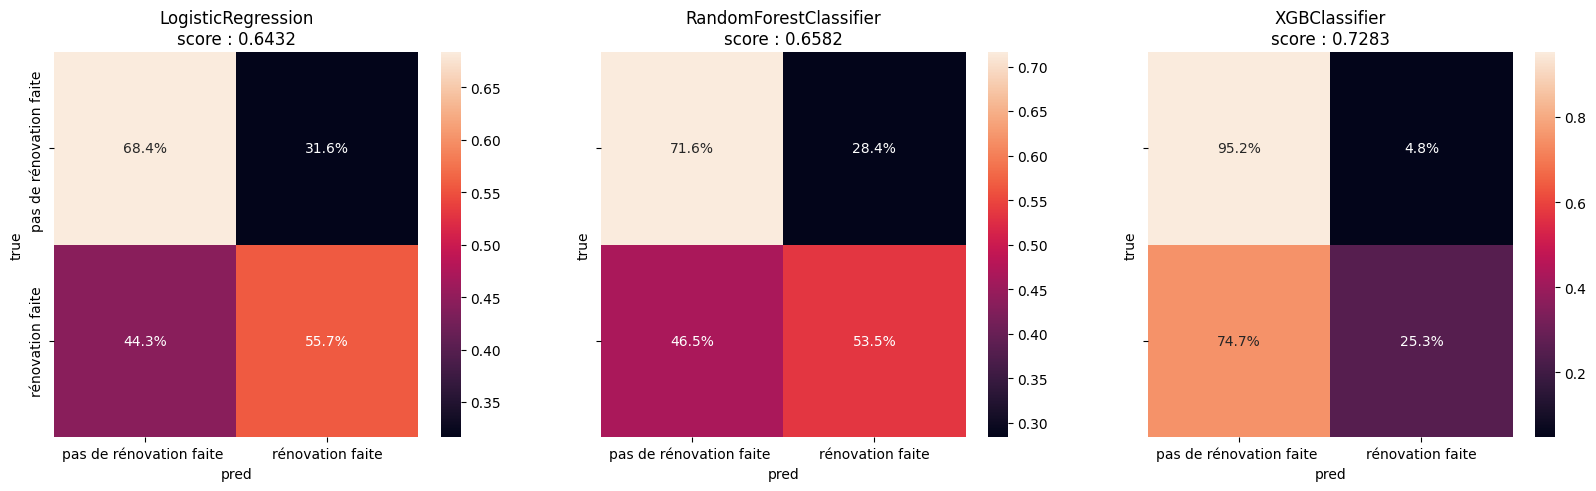

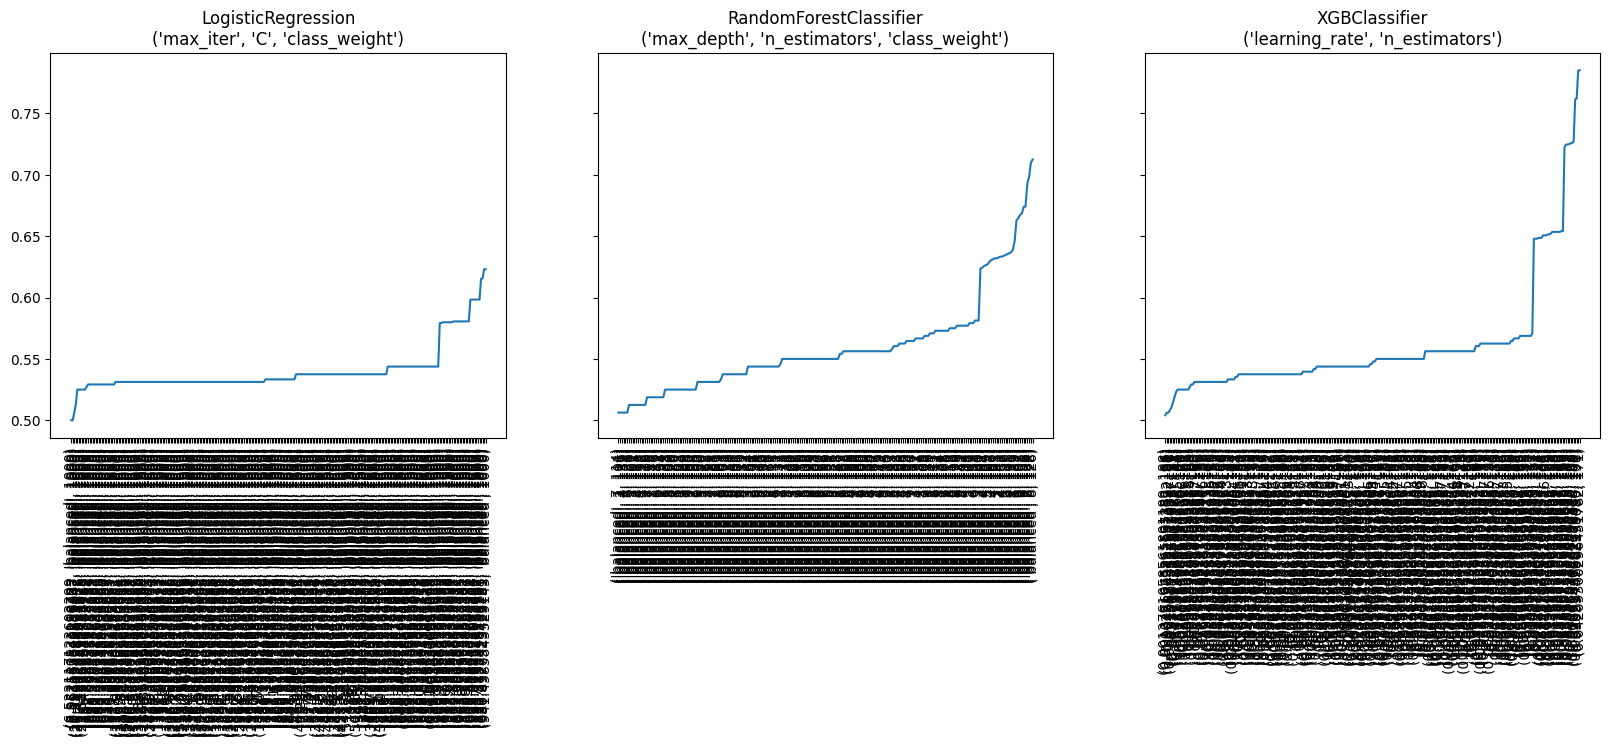

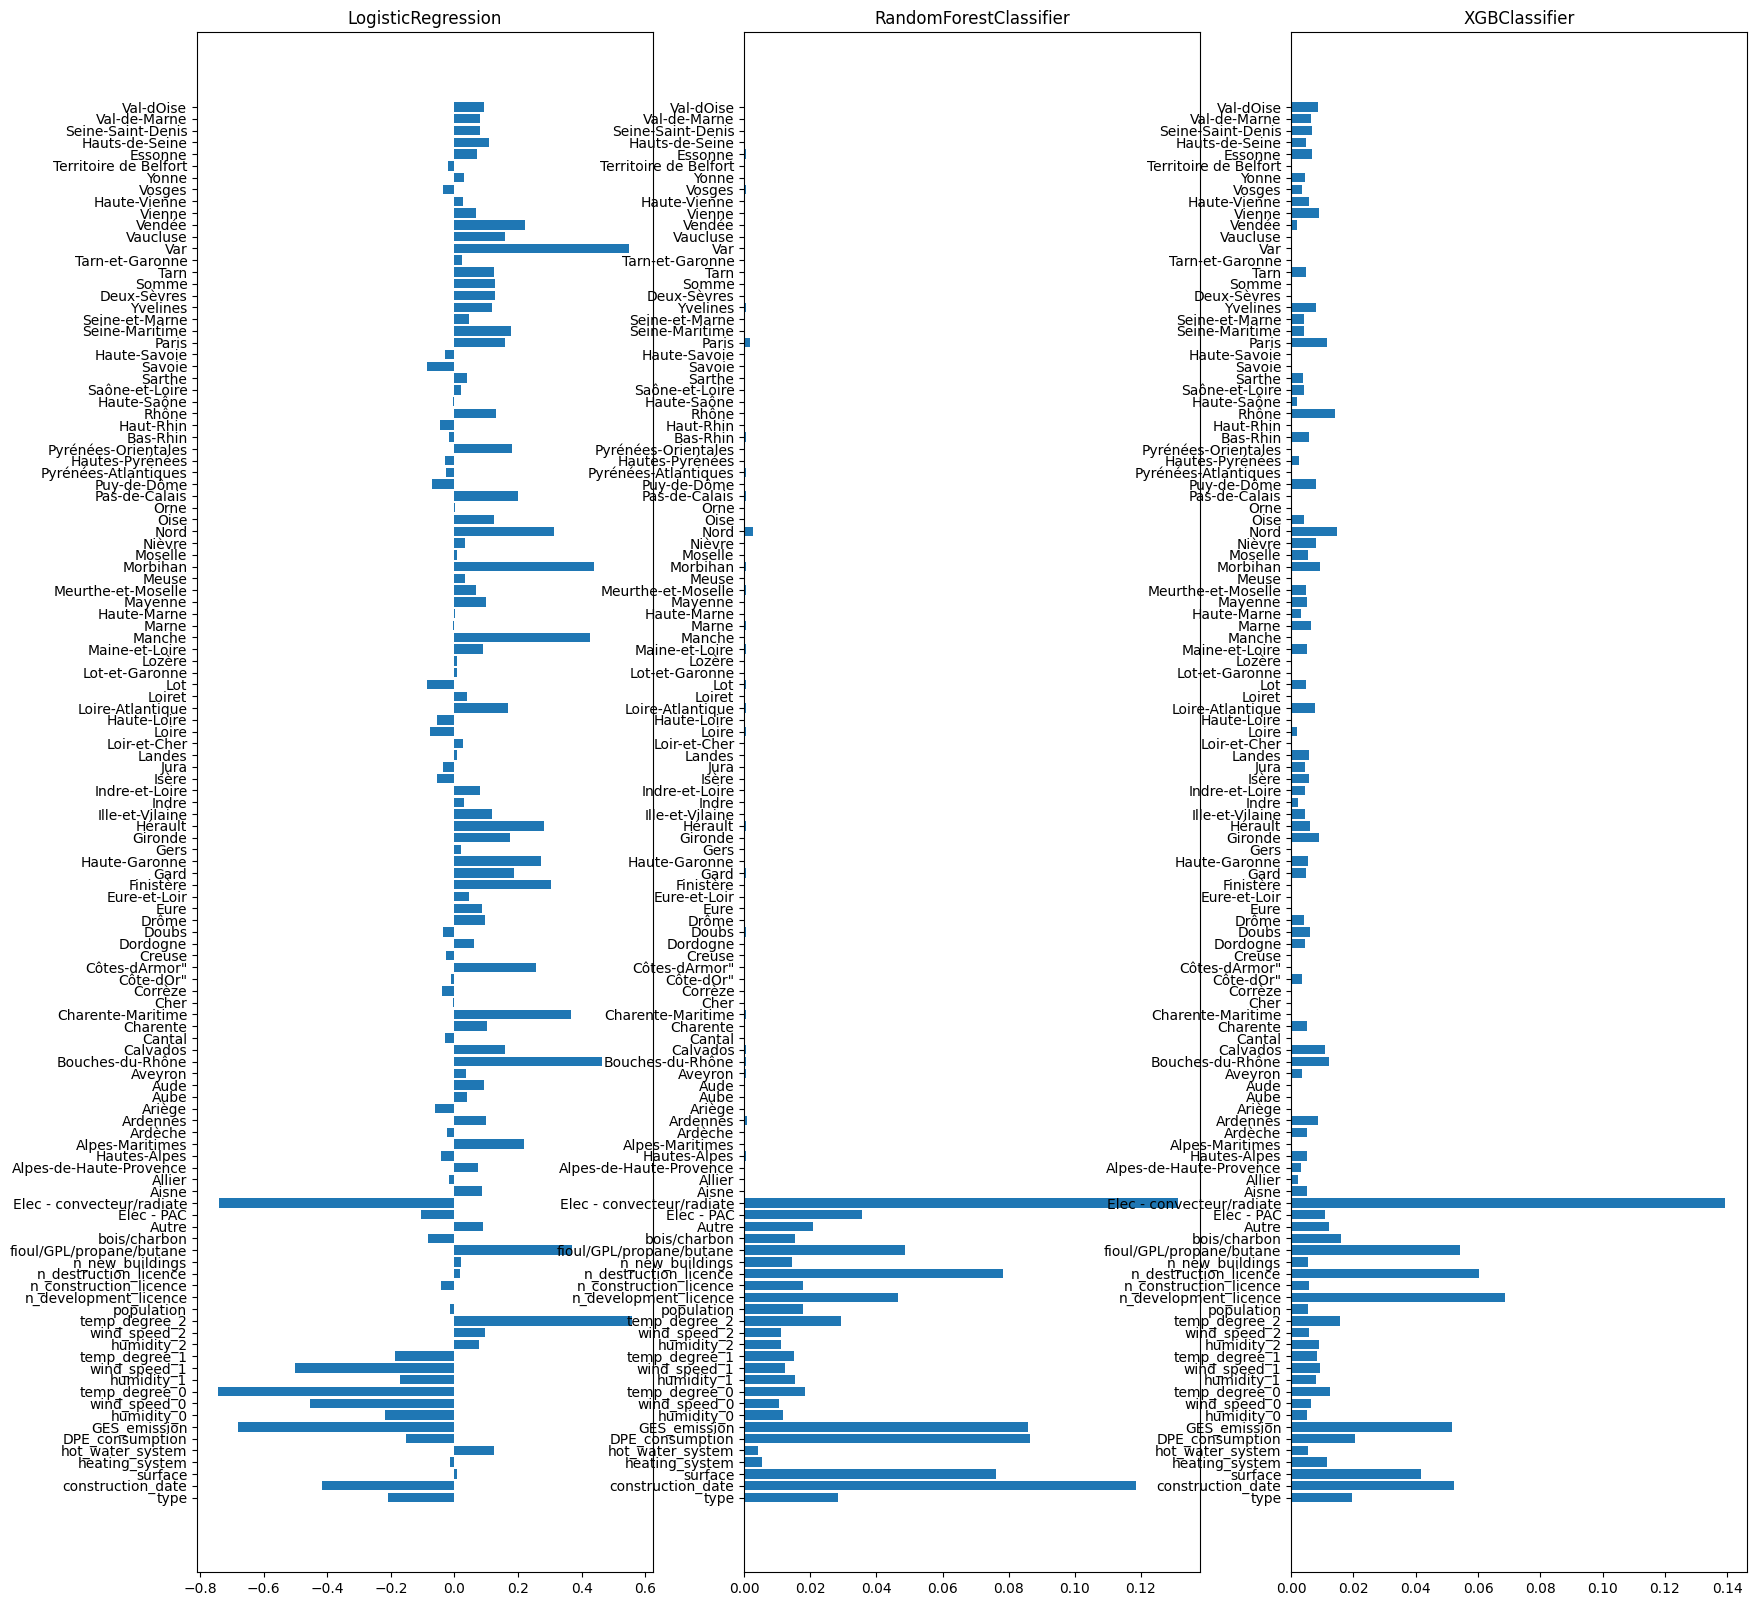

In [6]:
# get best model for the dataset
col_X_hot = [['heating_production', 'department_number'], ['heating_production', 'department_number'], ['heating_production', 'department_number']]
col_y = ["has_done_renov"]
col_X_not_hot = [
    [col[0] for col in training_renov_no_diff.dtypes if col[0] not in col_X_hot[i] + col_y]
    for i in range(len(col_X_hot))
]

categorical_features = [0, 1, 3, 4, 5, -2]


hyperparams_models = [
    {
        "max_iter": [1000],
        "C": uniform(1, 1000),
        "class_weight": ["balanced"],
    },
    {
        "max_depth": randint(1, 10),
        "n_estimators": randint(100, 200),
        "class_weight": ["balanced"],
    },
    {
        "learning_rate": uniform(0.001, 0.05),
        "n_estimators": randint(50, 200),
    },
]
models = {
    "LogisticRegression": LogisticRegression,
    "RandomForestClassifier": RandomForestClassifier,
    "XGBClassifier": XGBClassifier,
}

best_models_no_diff = prepare_train_show(
    training_renov_no_diff,
    dictionary,
    categorical_features,
    col_X_hot,
    col_X_not_hot,
    col_y,
    False,
    True,
    hyperparams_models,
    models,
    random_state=42,
    test_size=0.4,
    scoring="f1_micro",
    smote=True
)


In [7]:
# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# prepare data
from sklearn.model_selection import train_test_split
from lib.prepare_data import prepare_dataset

# scoring and training
from sklearn.metrics import f1_score
from lib.train import train_hyper, choose_params, nb_possibility, iterate_params
from sklearn.model_selection import cross_val_score

# insights
from lib.show import show_matrix